# 15.7 自然语言推断：微调BERT
- **目录**
  - 15.7.1 加载预训练的BERT
  - 15.7.2 微调BERT的SNLI数据集
  - 15.7.3 微调用于NLI的BERT
  - 15.7.4 微调BERT用于NLI预测

- 在本章的前面几节中，我们已经为SNLI数据集（ 15.4节）上的自然语言推断任务设计了一个基于注意力的结构（ 15.5节）。
- 现在，我们通过微调BERT来重新审视这项任务。
- 正如在 15.6节中讨论的那样，自然语言推断是一个序列级别的文本对分类问题，而微调BERT只需要一个额外的基于多层感知机的架构，如图15.7.1中所示。
<center><img src='../img/nlp-map-nli-bert.svg'></center>
<center>图15.7.1 将预训练BERT提供给基于多层感知机的自然语言推断架构</center><br>
- 在本节中，我们将下载一个预训练好的小版本的BERT，然后对其进行**微调**，以便在SNLI数据集上进行**自然语言推断**。

In [20]:
%matplotlib inline
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l

## 15.7.1 加载预训练的BERT
- 我们已经在 14.9节和 14.10节WikiText-2数据集上预训练BERT
  - 请注意，原始的BERT模型是在更大的语料库上预训练的。
- 正如在 14.10节中所讨论的，原始的BERT模型有数以亿计的参数。
- 在下面，我们提供了两个版本的预训练的BERT：
  - “bert.base”与原始的BERT基础模型一样大，需要大量的计算资源才能进行微调。
  - “bert.small”是一个小版本，以便于演示。

In [21]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
#官方没有small版，是教材提供的一个版本
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

- 两个预训练好的BERT模型都包含一个定义词表的“vocab.json”文件和一个预训练参数的“pretrained.params”文件。
- 我们实现了以下`load_pretrained_model`函数来**加载预先训练好的BERT参数**。


In [22]:
#load_pretrained_model两个主要任务：加载词表，加预训练好的参数
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # 定义空词表以加载预定义词表
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir,
        'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # 加载预训练BERT参数
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

- 为了便于在大多数机器上演示，我们将在本节中加载和微调经过预训练BERT的小版本（“bert.small”）。
- 微调大得多的“bert.base”以显著提高测试精度，附录中使用HuggingFace的transformers包微调bert-base-uncased版。


In [1]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

In [24]:
devices

[device(type='cuda', index=0)]

In [1]:
#bert

## 15.7.2 微调BERT的SNLI数据集
- 对于SNLI数据集的下游任务自然语言推断，我们定义了一个定制的数据集类SNLIBERTDataset。
- 在每个样本中，前提和假设形成一对文本序列，并被打包成一个BERT输入序列，如图15.6.2所示。
- 回想14.8.4节，片段索引用于区分BERT输入序列中的前提和假设。
- 利用预定义的BERT输入序列的最大长度（max_len），持续移除输入文本对中较长文本的最后一个词元，直到满足max_len。
- 为了加速生成用于微调BERT的SNLI数据集，我们使用4个工作进程并行生成训练或测试样本。


In [7]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]

        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # 使用4个进程
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # 为BERT输入中的'<CLS>'、'<SEP>'和'<SEP>'词元保留位置
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

- 下载完SNLI数据集后，我们通过实例化`SNLIBERTDataset`类来**生成训练和测试样本**。
- 这些样本将在自然语言推断的训练和测试期间进行小批量读取。


In [8]:
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
##修改解压错误，前面例子中已有详细介绍
#data_dir = d2l.download_extract('SNLI')
data_dir = r"../data/snli_1.0"
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples
read 9824 examples


## 15.7.3 微调用于NLI的BERT

- 如图15.7.1所示，用于自然语言推断的微调BERT只需要一个额外的多层感知机，该多层感知机由两个全连接层组成（请参见下面`BERTClassifier`类中的`self.hidden`和`self.output`）。
- **这个多层感知机将特殊的“&lt;cls&gt;”词元**的BERT表示进行了转换，该词元同时编码前提和假设的信息(**为自然语言推断的三个输出**)：蕴涵、矛盾和中性。


In [9]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        #额外的多层感知机
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

- 在下文中，预训练的BERT模型`bert`被送到用于下游应用的`BERTClassifier`实例`net`中。
- 在BERT微调的常见实现中，只有**额外的多层感知机（`net.output`）** 的输出层的参数将从零开始学习。
- 预训练BERT编码器（`net.encoder`）和额外的多层感知机的隐藏层（`net.hidden`）的所有参数都将进行微调。
  - **说明：** `net.hidden`是额外的多层感知机的隐藏层这个说法存疑，因为上述代码中`self.hidden = bert.hidden`，表示`net.hidden`是BERT预训练模型自带的层。

In [10]:
net = BERTClassifier(bert)

- 回想一下，在14.8节中，MaskLM类和NextSentencePred类在其使用的多层感知机中都有一些参数。
- 这些参数是预训练BERT模型bert中参数的一部分，因此是net中的参数的一部分。
- 然而，这些参数仅用于计算预训练过程中的遮蔽语言模型损失和下一句预测损失。
- **这两个损失函数与微调下游应用无关**，因此当BERT微调时，MaskLM和NextSentencePred中采用的多层感知机的参数不会更新（陈旧的，staled）。

- 我们通过该函数使用SNLI的训练集（train_iter）和测试集（test_iter）对net模型进行训练和评估。

loss 0.520, train acc 0.791, test acc 0.779
9786.4 examples/sec on [device(type='cuda', index=0)]


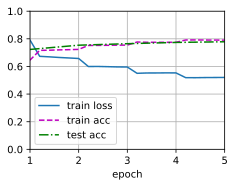

In [11]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
    devices)

### 15.7.4 微调BERT用于NLI预测

In [ ]:
def predict_snli(net, vocab, premise, hypothesis, max_len=128):
    """预测前提和假设之间的逻辑关系"""
    net.eval()
    
    # 分词并添加特殊标记
    p_tokens = ['<cls>'] + premise + ['<sep>']
    h_tokens = hypothesis + ['<sep>']
    
    # 截断以保证总长度不超过max_len-3（保留CLS和两个SEP的位置）
    while len(p_tokens) + len(h_tokens) > max_len - 3:
        if len(p_tokens) > len(h_tokens):
            p_tokens.pop()
        else:
            h_tokens.pop()
    
    # 生成BERT输入
    tokens = p_tokens + h_tokens
    segments = [0] * len(p_tokens) + [1] * len(h_tokens)
    valid_len = len(tokens)
    
    # 转换为ID并填充
    token_ids = torch.tensor(vocab[tokens] + [vocab['<pad>']] * (max_len - len(tokens)),
                           dtype=torch.long, device=d2l.try_gpu()).unsqueeze(0)
    segments = torch.tensor(segments + [0] * (max_len - len(segments)),
                          dtype=torch.long, device=d2l.try_gpu()).unsqueeze(0)
    valid_len = torch.tensor([valid_len], device=d2l.try_gpu())
    
    # 预测
    with torch.no_grad():
        output = net((token_ids, segments, valid_len))
        label = torch.argmax(output, dim=1).item()
    
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [17]:
# 使用示例
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'very', 'bad', '.'])

'neutral'

In [16]:
predict_snli(net, vocab, ['he', 'is', 'bad', '.'], ['he', 'is', 'very', 'bad', '.'])

'entailment'

## 小结

* 我们可以针对下游应用对预训练的BERT模型进行微调，例如在SNLI数据集上进行自然语言推断。
* 在微调过程中，BERT模型成为下游应用模型的一部分。仅与训练前损失相关的参数在微调期间不会更新。

------
- **附录：使用HuggingFace预训练BERT模型微调用于自然语言推断**


In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda')

- 数据预处理

In [3]:
# 加载SNLI数据集
#dataset = load_dataset("snli")
# 假设数据文件在本地目录
dataset = load_dataset(
    'json',
    data_files={
        'train': r'../data/snli_1.0/snli_1.0_train.jsonl',
        'validation':  r'../data/snli_1.0/snli_1.0_dev.jsonl',
        'test':  r'../data/snli_1.0/snli_1.0_test.jsonl'
    }
)

Found cached dataset json (/home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# 定义标准转换函数
def convert_to_snli_format(example):
    return {
        'premise': example['sentence1'],
        'hypothesis': example['sentence2'],
        'label': ['entailment', 'neutral', 'contradiction'].index(example['gold_label'])
        # 注意：原始SNLI使用-1表示无效标签
        if example['gold_label'] in ['entailment', 'neutral', 'contradiction']
        else -1
    }

# 应用格式转换
dataset = dataset.map(convert_to_snli_format)

Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-f3346bb82a0a8c25.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-e8d60ca8b23ce03d.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-5d7d31054e5081ae.arrow


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['annotator_labels', 'captionID', 'gold_label', 'pairID', 'sentence1', 'sentence1_binary_parse', 'sentence1_parse', 'sentence2', 'sentence2_binary_parse', 'sentence2_parse', 'premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['annotator_labels', 'captionID', 'gold_label', 'pairID', 'sentence1', 'sentence1_binary_parse', 'sentence1_parse', 'sentence2', 'sentence2_binary_parse', 'sentence2_parse', 'premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['annotator_labels', 'captionID', 'gold_label', 'pairID', 'sentence1', 'sentence1_binary_parse', 'sentence1_parse', 'sentence2', 'sentence2_binary_parse', 'sentence2_parse', 'premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [6]:
tokenizer = BertTokenizer.from_pretrained('../weights/bert-base-uncased')

In [7]:
def preprocess_function(examples):
    # 处理前提和假设对
    return tokenizer(
        examples['premise'], 
        examples['hypothesis'],
        max_length=128,
        truncation=True,
        padding='max_length'
    )

# 过滤掉标签为-1的样本
dataset = dataset.filter(lambda x: x['label'] != -1)

# 应用tokenizer
encoded_dataset = dataset.map(preprocess_function, batched=True)

# 设置PyTorch格式
encoded_dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-05a5229ac910979f.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-1bbba2e362e297eb.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-d14c1c1a71dbb7f8.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cache-3dca12ae932de6f1.arrow
Loading cached processed dataset at /home/user/.cache/huggingface/datasets/json/default-fc76ed847f12a71e/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4/cach

- 创建数据加载器

In [8]:
batch_size = 128

train_loader = DataLoader(
    encoded_dataset['train'],
    shuffle=True,
    batch_size=batch_size
)

val_loader = DataLoader(
    encoded_dataset['validation'],
    batch_size=batch_size
)

test_loader = DataLoader(
    encoded_dataset['test'],
    batch_size=batch_size
)

- 模型初始化

In [9]:
model = BertForSequenceClassification.from_pretrained(
    '../weights/bert-base-uncased',
    num_labels=3  # SNLI有3个类别
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../weights/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- 训练设置

In [10]:
epochs = 1
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss()

- 训练函数

In [11]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device),
            'token_type_ids': batch['token_type_ids'].to(device),
            'labels': batch['label'].to(device)
        }
        
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    return total_loss / len(dataloader)

- 评估函数

In [12]:
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'token_type_ids': batch['token_type_ids'].to(device)
            }
            
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())
    
    return accuracy_score(true_labels, predictions)

- 训练循环

In [13]:
best_val_acc = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # 训练
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss:.4f}")
    
    # 验证
    val_acc = evaluate(model, val_loader, device)
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), r"../weights/best_bert_snli_model.pt")
        print("Saved best model!")


Epoch 1/1


Training: 100%|███████████████████████████████████████████████████████████████| 4292/4292 [40:42<00:00,  1.76it/s]


Train Loss: 0.4022


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 77/77 [00:14<00:00,  5.20it/s]


Validation Accuracy: 0.8955
Saved best model!


- 测试评估

In [13]:
# 加载最佳模型
model.load_state_dict(torch.load(r"../weights/best_bert_snli_model.pt"))
test_acc = evaluate(model, test_loader, device)
print(f"\nTest Accuracy: {test_acc:.4f}")

Evaluating: 100%|█████████████████████████████████████████████████████████████████| 77/77 [00:14<00:00,  5.33it/s]


Test Accuracy: 0.8964


-  预测函数

In [14]:
def predict_snli(premise, hypothesis):
    # 预处理输入
    inputs = tokenizer(
        premise,
        hypothesis,
        max_length=128,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    # 预测
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    
    label_map = {0: "entailment", 1: "neutral", 2: "contradiction"}
    return label_map[pred]

# 使用示例
example_premise = "A soccer game with multiple males playing."
example_hypothesis = "Some men are playing a sport."
print(predict_snli(example_premise, example_hypothesis))  # 输出: entailment

entailment


In [17]:
# 使用示例
example_premise = "A man is jogging in the park."
example_hypothesis = "The man is a marathon runner."
print(predict_snli(example_premise, example_hypothesis))  # 输出: neutral

neutral


In [18]:
# 使用示例
example_premise = "The store closes at 6 PM sharp."
example_hypothesis = "The store remains open until 9 PM."
print(predict_snli(example_premise, example_hypothesis))  # 输出: contradiction

contradiction


- GPU使用情况

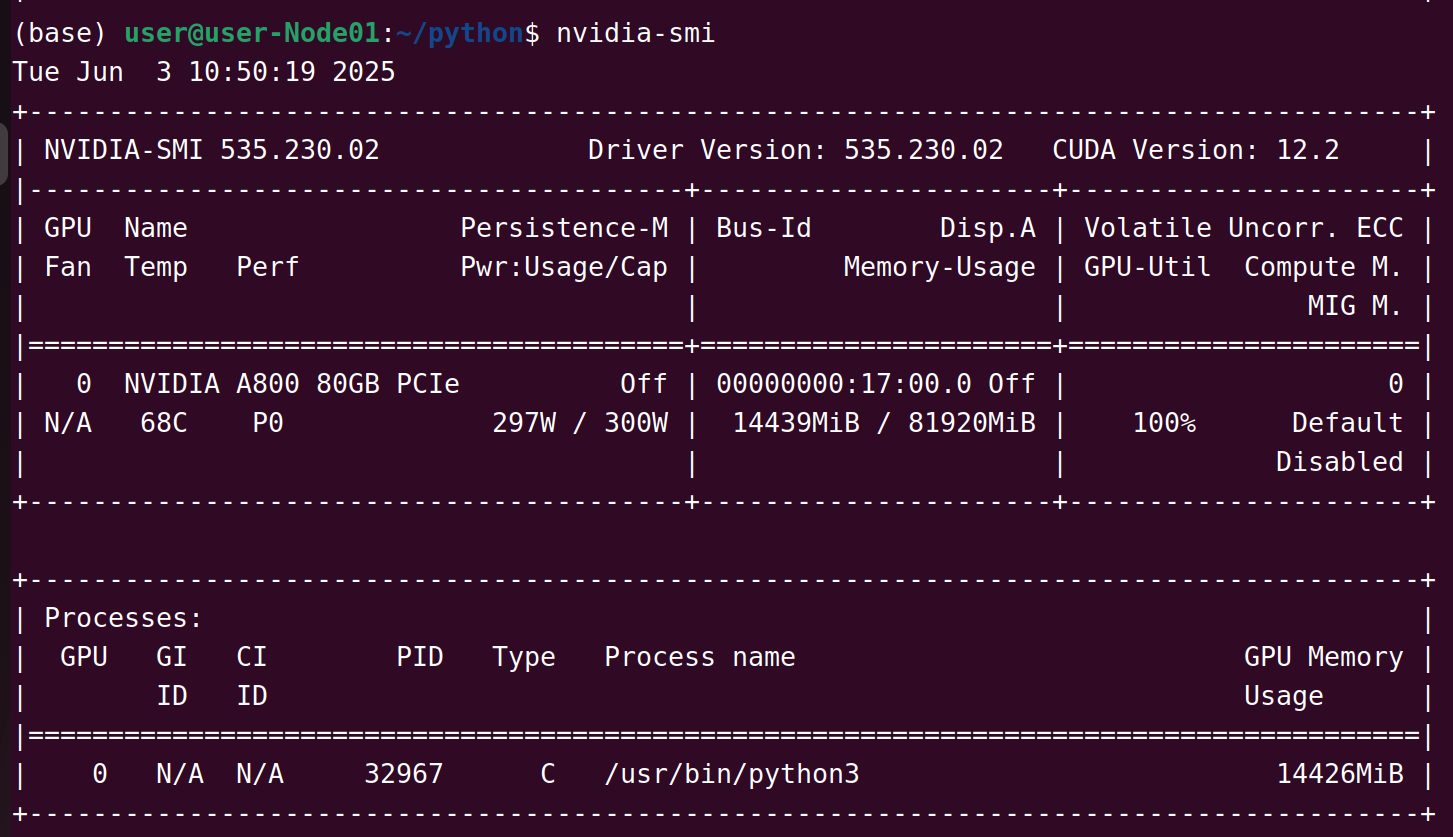

-------